In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import timm

from pytorch_models_imp.visual_transformer import PatchEmbeddings, SelfAttention, TransformerBlock, VisionTransformer

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=5)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=5)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(img, label):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[label])
    plt.show()

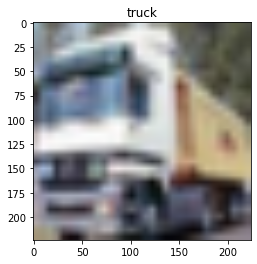

In [6]:
indx = 1
example = trainset[indx]
imshow(example[0], example[1])

In [7]:
images, labels = next(iter(trainloader))

### Images to patches

In [8]:
PATCH_SIZE = 16
EMBEDDING_SIZE = 192
DROPOUT = 0.0
HEADS = 3
FORWARD_EXPANSION = 4
NUM_LAYERS = 12

IMAGE_SIZE = example[0].shape[1]
B, C, H, W = images.shape

In [9]:
patch_embedder = PatchEmbeddings(IMAGE_SIZE, PATCH_SIZE, EMBEDDING_SIZE, DROPOUT)
print(f"NUM OF PATCHES: {patch_embedder.num_of_patches}")
out = patch_embedder(images)
assert out.shape == (B, patch_embedder.num_of_patches + 1, EMBEDDING_SIZE)  # batch, number_of_patches + 1, embed_size

NUM OF PATCHES: 196


### Self attention

In [10]:
self_attention = SelfAttention(HEADS, EMBEDDING_SIZE, DROPOUT)
attention = self_attention(out, out, out)
assert attention.shape == (B, patch_embedder.num_of_patches + 1, EMBEDDING_SIZE)

### Transformer block

In [11]:
transformer_block = TransformerBlock(HEADS, EMBEDDING_SIZE, FORWARD_EXPANSION, DROPOUT)

In [12]:
transformer_out = transformer_block(out)
assert transformer_out.shape == (B, patch_embedder.num_of_patches + 1, EMBEDDING_SIZE)

### Vision transformer

In [13]:
NUM_CLASSES = len(classes)
vision_transformer = VisionTransformer(IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, HEADS, EMBEDDING_SIZE, FORWARD_EXPANSION, NUM_LAYERS, DROPOUT)

In [14]:
# summary(vision_transformer)

In [15]:
out = vision_transformer(images)
assert out.shape == (B, NUM_CLASSES)

### TIMM model

In [31]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model = 'vit_base_patch32_224'
# model = 'efficientnet_b0'

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

timm_vit = timm.create_model(model, pretrained=True, num_classes=NUM_CLASSES)

In [32]:
with torch.no_grad():
    %timeit out = timm_vit(images[0:1, ...])

300 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
